In [1]:
import asyncio
import re
import os
import pandas as pd
import base64
import io
from PIL import Image
import base64
from io import BytesIO
from openai import AsyncOpenAI, OpenAI
from dotenv import load_dotenv
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential, stop_after_delay,
)

# Load environment variables
load_dotenv()

True

In [15]:
def describe_data_list(data_path_list):
    try:
        data_description_list = []
        for data_path in data_path_list:
            root_path = os.path.abspath(os.path.join(os.path.dirname(os.curdir), '../../..'))
            data_path = os.path.normpath(os.path.join(root_path, data_path))
            # single_data_description = describe_data(data_path)
            # data_description_list.append(single_data_description)
        data_description = "[" + "], [".join(data_description_list) + "]"
    except:
        data_description = 'There is no dataset provided, please generate code based on the content of query.'

    return data_description

data_path_list = ['./matplotbench/dataset/data/95/data.csv']

describe_data_list(data_path_list)

'[]'

In [9]:
data_path = 'vispath/matplotbench/dataset/data/98/data.csv'
root_path = os.path.abspath(os.path.join(os.path.dirname(os.curdir), '../../../..'))
print(root_path)
data_path = os.path.normpath(os.path.join(root_path, data_path))
print(data_path)


c:\Users\LeeSeungYong\myproject\[논문] AI Agent 기반 Data Visualization 프레임워크 연구 (VisPath)
c:\Users\LeeSeungYong\myproject\[논문] AI Agent 기반 Data Visualization 프레임워크 연구 (VisPath)\vispath\matplotbench\dataset\data\98\data.csv


In [9]:
print(os.curdir)

NameError: name 'os' is not defined

In [290]:
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")
model = 'gpt-4o-mini'
temperature = 0.2
client = AsyncOpenAI(
    api_key=api_key,
    base_url=base_url
)

# system_prompt_expansion=system_prompt_expansion or "You are an expert on extend data visualization query. You should think step by step, and write the extended queries in the Python List format like ```[query_text_1, query_text_2, query_text_3]```."
system_prompt_expansion= '''According to the user query, expand and solidify the query into a step by step detailed instruction (or comment) on how to write python code to fulfill the user query's requirements. Import the appropriate libraries. Pinpoint the correct library functions to call and set each parameter in every function call accordingly.'''

# template_expansion = """
# Think step by step. Generate three distinct extended queries based on the given query.
# Make sure to analyze the given data description first and create queries that make sense for the data. 
# If there are not data description provided, then just follow the original query. You must follow the Python list format for output.
# And do not change the detailed instructions in the original user query

# The original query is: {ori_query}

# Data description is: {data_description}

# Output format: ```[query_text_1, query_text_2, query_text_3]``` 
# """

template_expansion = """
Generate three distinct extended queries based on the given original query.  
Each extended query should be written in a Chain of Thought (CoT) style, explicitly outlining the reasoning and step-by-step methodology to achieve the goal.  

### **Key Requirements:**  
- Do NOT change the goal or instructions given in the original query.  
- Propose **three different methodologies** to achieve the goal while maintaining the original intent.  
- Each extended query must be structured in a step-by-step CoT format, explaining **why** each step is necessary.  
- The different methodologies should vary in terms of **data processing, visualization techniques, or computation strategies**.  
- Ensure that the data description is analyzed and incorporated into the query design.  
- If no data description is provided, then strictly follow the original query.  

### **Variations in Approach (Examples):**  
- Using different **data processing techniques** (e.g., pandas, NumPy, direct iteration)  
- Implementing various **visualization strategies** (e.g., different libraries, different styles of plots)  
- Exploring alternative **computation methods** (e.g., vectorized operations, grouped aggregations, iterative filtering)  

### **Input:**  
The original query is: {ori_query}  

Data description is: {data_description}  

### **Output Format:**  
Return the output **ONLY** in the following Python list format:  
```[query_text_1, query_text_2, query_text_3]```  
"""



system_prompt_codegen= """You are an expert on data visualization code generation. You should think step by step, and write the generated code in the format of ```python...```, where ... indicates the generated code. Code Must end in plt.show() and don't save figure by plt.savefig() and don't save anything else either."""
template_codegen= """\
        Based on the user's query and data description, generate Python code using Visualization Library like `matplotlib.pyplot` or 'seaborn' to create the requested plot. Ensure the code is outputted within the format ```...```, where ... indicates the generated code. Please make sure to generate the code according to the data description below. Do not include unnecessary code for saving plot figure, saving dataframe, or other unrelated tasks when generating the code. End with plt.show() and do not include anything after that.

        User query: {query}

        Data description: {data_description}
        """
system_prompt_aggregation= """
        You are an expert in analyzing, improving, and synthesizing data visualization code. 
        Your role is to evaluate multiple versions of visualization code based on user queries and data descriptions, 
        integrate feedback effectively, and generate a final version that best meets the user's requirements."
"""

template_aggregation= """\
    Think step by step and plan before generating the final code.

You will be given:
- **User Query**: Instructions on how the user wants the data visualization (plot) to be performed.
- **Data Description**: Details about the dataset, including file paths and summaries.
- **Code for Aggregation with Corresponding Feedback**: Three different versions of the data visualization code, each paired with its respective feedback highlighting mismatches with the user’s requirements and areas for improvement.

### **Your Task:**
1. **Understand the User's Intent**  
   - Analyze the **User Query** to extract key visualization requirements, constraints, and goals.
   - Carefully review the **Data Description** to ensure the final visualization correctly utilizes the given dataset.

2. **Evaluate the Provided Code Versions & Feedback**  
   - Examine all three versions of the code.
   - Review the feedback for each version and identify common issues, missing elements, and improvement points.
   - Determine which parts of each version align well with the user's requirements.

3. **Synthesize the Best Final Version**  
   - Construct a final version that effectively **integrates the best aspects** of the provided codes while addressing all necessary corrections from the feedback.  
   - Ensure the final code adheres to **high readability, clarity, and maintainability** while fully complying with the user’s original instructions.  
   - Eliminate unnecessary complexity while maintaining functionality.

4. **Output the Final Version**  
   - Provide the optimized final version inside a properly formatted code block:
     ```
     ```python
     # Final optimized code
     ...
     ```
     ```

### **Inputs:**
- **User Query:** {ori_query}
- **Data Description:** {data_description}
- **Code for Aggregation with Corresponding Feedback:** {code_for_aggregation}
"""

In [107]:
matplotbench_csv = os.path.abspath(os.curdir).split('model')[0] + '\\dataset\\matplotbench_data.csv'
data = pd.read_csv(matplotbench_csv)
id = 95
simple_instruction = data.iloc[id - 1, 1]
ground_truth = data.iloc[id - 1, -1]
data_path_list = [f'./matplotbench/dataset/data/{id}/data.csv']

In [108]:
ground_truth_img_path = './groundtruth.png'
with open(ground_truth_img_path, 'wb') as img_file:
    img_file.write(base64.b64decode(ground_truth))

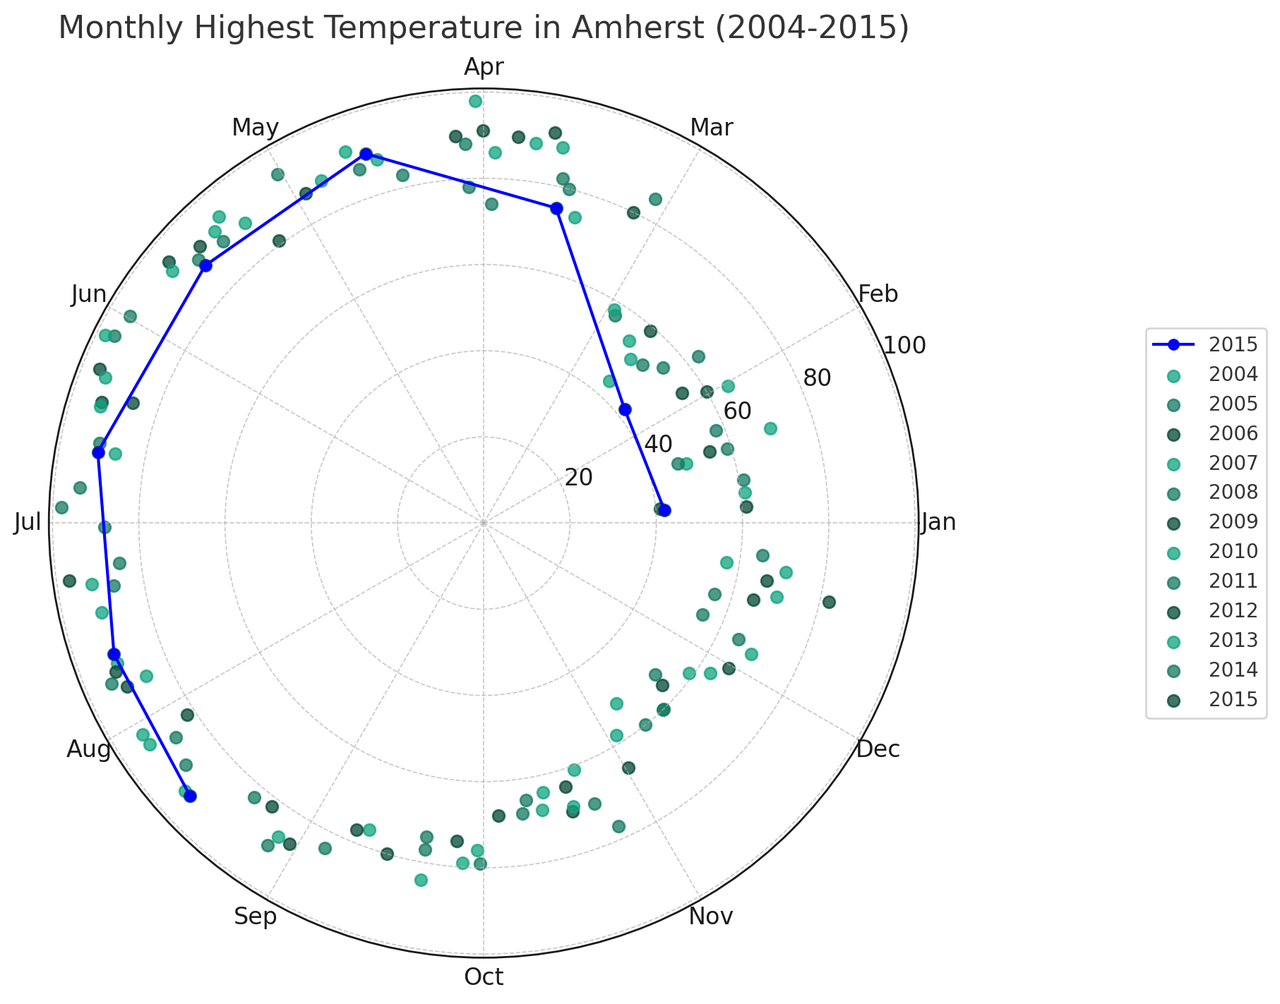

In [109]:
from PIL import Image
Image.open(ground_truth_img_path)

In [110]:
def describe_data(data_path):
    # Read the data file using pandas
    data = pd.read_csv(data_path)
    description = {
        "data_path": data_path,
        "columns": list(data.columns),
        "dtypes": data.dtypes.to_dict(),
        "shape": data.shape,
    }
    return str(description)

def describe_data_list(data_path_list):
    try:
        data_description_list = []
        for data_path in data_path_list:
            single_data_description = describe_data(data_path)
            data_description_list.append(single_data_description)
        data_description = "[" + "], [".join(data_description_list) + "]"
    except:
        data_description = 'There is no dataset provided, please generate code based on the content of query.'

    return data_description

In [111]:
data_path_list

['./matplotbench/dataset/data/95/data.csv']

In [112]:
data_description_list = []
for data_path in data_path_list:
    root_path = os.path.abspath(os.path.join(os.path.dirname(os.curdir), '../../..'))
    # print(root_path)

    # 절대 경로로 'matplotbench/dataset/matplotbench_data.csv' 경로 설정
    data_path = os.path.normpath(os.path.join(root_path, './matplotbench/dataset/data/95/data.csv'))

    # print(data_path)

    single_data_description = describe_data(data_path)
    data_description_list.append(single_data_description)
data_description = "[" + "], [".join(data_description_list) + "]"

In [127]:
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")
model = 'gpt-4o-mini'
temperature = 0.2
client = AsyncOpenAI(
    api_key=api_key,
    base_url=base_url
)

In [141]:
prompt = template_expansion.format(
        ori_query=simple_instruction,
        data_description = data_description
        )

In [142]:
print(prompt)


Generate three distinct extended queries based on the given original query.  
Each extended query should be written in a Chain of Thought (CoT) style, explicitly outlining the reasoning and step-by-step methodology to achieve the goal.  

### **Key Requirements:**  
- Do NOT change the goal or instructions given in the original query.  
- Propose **three different methodologies** to achieve the goal while maintaining the original intent.  
- Each extended query must be structured in a step-by-step CoT format, explaining **why** each step is necessary.  
- The different methodologies should vary in terms of **data processing, visualization techniques, or computation strategies**.  
- Ensure that the data description is analyzed and incorporated into the query design.  
- If no data description is provided, then strictly follow the original query.  

### **Variations in Approach (Examples):**  
- Using different **data processing techniques** (e.g., pandas, NumPy, direct iteration)  
- 

In [143]:
response = await client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt_expansion},
                {"role": "user", "content": prompt}
            ],
            temperature=temperature
        )

In [146]:
response_text = response.choices[0].message.content

In [147]:
print(simple_instruction)

Create a polar coordinate diagram using data from "data.csv" to display the highest temperatures on the first of each month in Amherst, spanning from January 1, 2004, to August 1, 2015. The data includes columns labeled "Year," "Date," and "Temperature." The diagram should include:

- 12 sectors, each representing a month of the year.
- Temperature data plotted according to the corresponding month.
- Circular points for the temperature data, slightly offset to prevent alignment along a single radial line.
- Abbreviated labels for the months (Jan, Feb, Mar, etc.).
- A blue curve that connects the data points from the year 2015.
- A legend positioned on the right side of the diagram.
- A title: "Monthly Highest Temperature in Amherst (2004-2015)."
The purpose of the diagram is to clearly illustrate the temperature trends and monthly variations over the years, with an emphasis on the data from 2015.


In [179]:
print(response_text)

```python
[
    """
    1. **Using Pandas for Data Processing and Matplotlib for Visualization**:
    
    - **Step 1**: Import the necessary libraries. We will use `pandas` for data manipulation and `matplotlib` for plotting.
        ```python
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        ```
    
    - **Step 2**: Load the data from the CSV file into a DataFrame. This allows us to easily manipulate and analyze the data.
        ```python
        data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')
        ```
    
    - **Step 3**: Convert the 'Date' column to datetime format to facilitate date manipulation.
        ```python
        data['Date'] = pd.to_datetime(data['Date'])
        ```
    
    - **Step 4**: Filter the data to include only the highest temperatures on the first of each month from January 2004 to August 2015. We can use `groupby` and `max` to achieve this

In [149]:
@retry(wait=wait_random_exponential(min=0.02, max=1), stop=(stop_after_delay(3) | stop_after_attempt(30)))
async def call_openai_api(system_prompt, user_content):
    try:
        response = await client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_content}
            ],
            temperature=temperature
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"API call failed with error: {e}. Retrying...")
        raise e

In [153]:
match = re.search(r'\[.*\]', response_text, flags=re.DOTALL)
if match:
    generated_query = match.group().strip()
    try:
        parsed_list = ast.literal_eval(generated_query)
        # print(parsed_list)
        if isinstance(parsed_list, list) and parsed_list:
            extend_query_list = parsed_list
        else:
            extend_query_list = None
    except (ValueError, SyntaxError) as e:
        extend_query_list = None
else:
    print("No match found")
    extend_query_list = None

In [159]:
async def single_codegen(query, data_description):
        # Call API and return the generated code
        prompt=template_codegen.format(
                query=query,
                data_description=data_description,
                )
        print('Single Code Generating...')
        response_text = await call_openai_api(system_prompt_codegen, prompt)
        match = re.search(r"```python(.*?)```", response_text, flags=re.DOTALL)
        if match:
            code_content = match.group(1).strip()
            return code_content
        else:
            return None

In [161]:
tasks = [single_codegen(query, data_description) for query in extend_query_list]
generated_code_list = await asyncio.gather(*tasks)

Single Code Generating...
Single Code Generating...
Single Code Generating...


In [181]:
print(extend_query_list[0])


    1. **Using Pandas for Data Processing and Matplotlib for Visualization**:
    
    - **Step 1**: Import the necessary libraries. We will use `pandas` for data manipulation and `matplotlib` for plotting.
        ```python
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        ```
    
    - **Step 2**: Load the data from the CSV file into a DataFrame. This allows us to easily manipulate and analyze the data.
        ```python
        data = pd.read_csv('c:\Users\LeeSeungYong\myproject\vispath\matplotbench\dataset\data\95\data.csv')
        ```
    
    - **Step 3**: Convert the 'Date' column to datetime format to facilitate date manipulation.
        ```python
        data['Date'] = pd.to_datetime(data['Date'])
        ```
    
    - **Step 4**: Filter the data to include only the highest temperatures on the first of each month from January 2004 to August 2015. We can use `groupby` and `max` to achieve this.
        ```python
        

In [180]:
print(generated_code_list[0])

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')
data['Date'] = pd.to_datetime(data['Date'])

data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
monthly_max = data[data['Day'] == 1].groupby('Month')['Temperature'].max().reset_index()

angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.plot(angles, temperatures_offset, 'o', color='orange', label='Monthly Max Temp')
ax.plot(angles, temperatures_offset

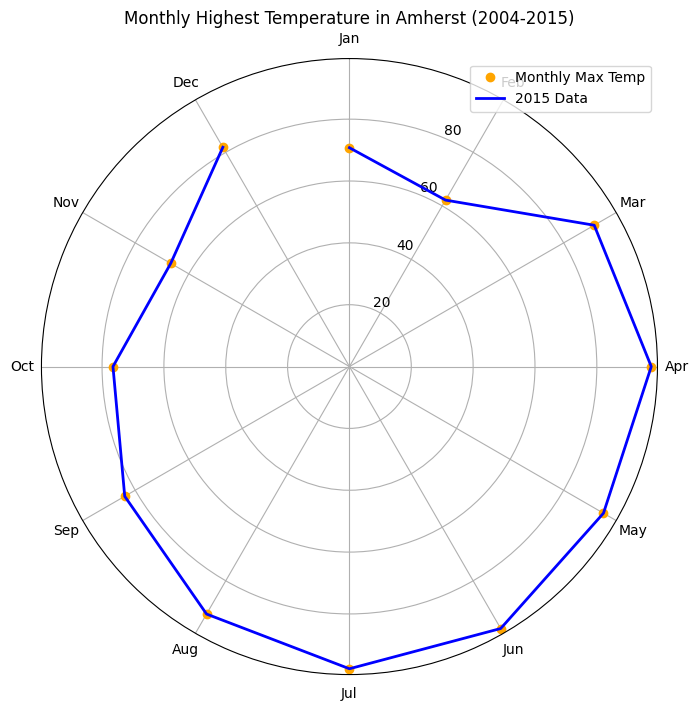

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')
data['Date'] = pd.to_datetime(data['Date'])

data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
monthly_max = data[data['Day'] == 1].groupby('Month')['Temperature'].max().reset_index()

angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.plot(angles, temperatures_offset, 'o', color='orange', label='Monthly Max Temp')
ax.plot(angles, temperatures_offset, color='blue', linewidth=2, label='2015 Data')
ax.set_title('Monthly Highest Temperature in Amherst (2004-2015)')
ax.legend(loc='upper right')
plt.show()

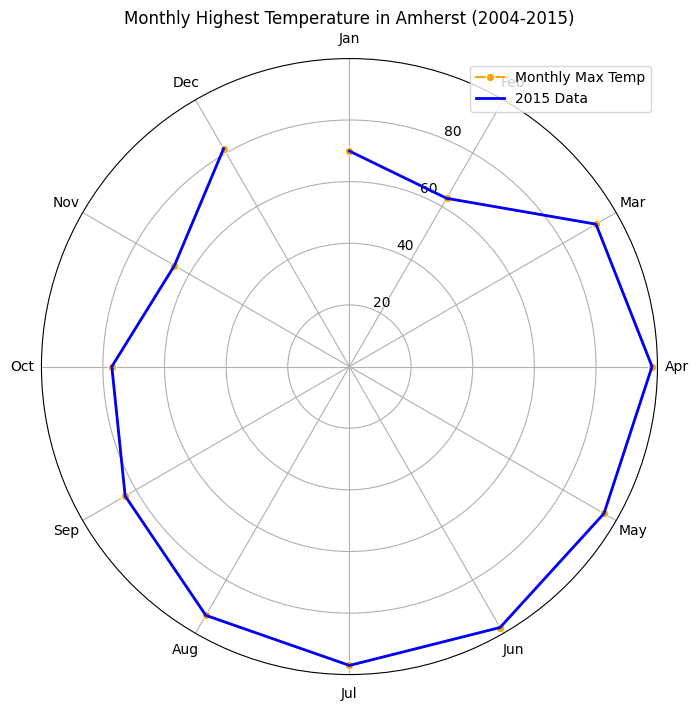

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Extract the month and filter for the first day of each month, then find the maximum temperature for each month
data['Month'] = data['Date'].dt.month
monthly_max = data[data['Date'].dt.day == 1].groupby('Month')['Temperature'].max().reset_index()

# Prepare the angles for the polar plot and add a slight random offset to the temperature values
angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-0.5, 0.5, size=temperatures.shape)

# Create a polar plot using Seaborn's style for better aesthetics
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
sns.lineplot(x=angles, y=temperatures_offset, marker='o', color='orange', label='Monthly Max Temp', ax=ax)
sns.lineplot(x=angles, y=temperatures_offset, color='blue', linewidth=2, label='2015 Data', ax=ax)
ax.set_title('Monthly Highest Temperature in Amherst (2004-2015)')
ax.legend(loc='upper right')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (12,) and (13,)

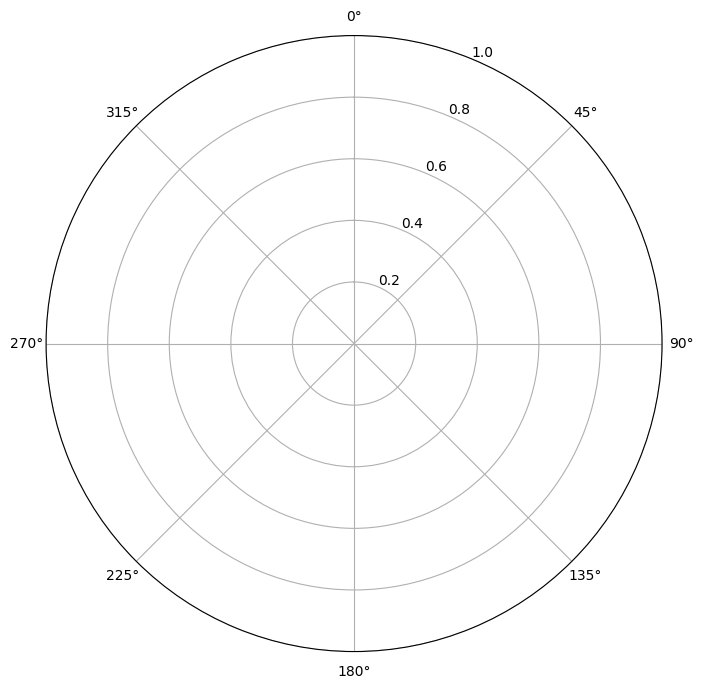

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Initialize a list to hold the maximum temperatures for the first of each month
monthly_max = []
for month in range(1, 13):
    max_temp = data[(data['Date'].dt.month == month) & (data['Date'].dt.day == 1)]['Temperature'].max()
    monthly_max.append(max_temp)

# Prepare the angles for the polar plot
angles = [i * (2 * np.pi / 12) for i in range(12)]
temperatures_offset = [temp + np.random.uniform(-0.5, 0.5) for temp in monthly_max]  # Offset for visibility

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw the plot
ax.plot(angles, temperatures_offset + [temperatures_offset[0]], color='blue', linewidth=2, label='Monthly Max Temp')
ax.fill(angles, temperatures_offset + [temperatures_offset[0]], color='orange', alpha=0.25)

# Set the labels for each month
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'Month {i+1}' for i in range(12)])

# Set title
plt.title('Monthly Highest Temperature in Amherst (2004-2015)')
plt.legend(loc='upper right')
plt.show()

In [184]:
generated_code_list

["import pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ndata = pd.read_csv('c:\\\\Users\\\\LeeSeungYong\\\\myproject\\\\vispath\\\\matplotbench\\\\dataset\\\\data\\\\95\\\\data.csv')\ndata['Date'] = pd.to_datetime(data['Date'])\n\ndata['Month'] = data['Date'].dt.month\ndata['Day'] = data['Date'].dt.day\nmonthly_max = data[data['Day'] == 1].groupby('Month')['Temperature'].max().reset_index()\n\nangles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()\ntemperatures = monthly_max['Temperature'].values\ntemperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility\n\nfig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))\nax.set_theta_offset(np.pi / 2)\nax.set_theta_direction(-1)\nax.set_xticks(angles)\nax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])\nax.plot(angles, temperatures_offset, 'o', color='orange', label='Monthly Max Te

In [266]:
def code_to_image(code, img_save_path):
    import matplotlib.pyplot as plt
    exec_globals = {"plt": plt, "io": io}
    exec_locals = {}
    print('Start Executing Code and Save Final Image')
    try:
        code_n = code.replace("plt.show()", f"plt.savefig('{img_save_path}')\nplt.close('all')")
        exec(code_n, exec_globals, exec_locals)
        message = "Save Image Successfully!"
        print(message)
        return True, None
    except Exception as e:
        message = f'''There are some errors in the code you gave:
{str(e)}
please correct the errors.'''
        print(message)
        return False, message

def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

In [267]:
async def visual_feedback(ori_query, code, img_path):
        print("Visaul Feedback generating...")
        # Save the plot as an image using the provided code
        success, error_message = code_to_image(code, img_path)

        if not success:
            base64_image = error_message  # Return an error message if image saving fails
        else:
            # Encode the image to base64 for sending as a message
            base64_image = encode_image(img_path)
        # Prepare the messages for GPT-4o, including the system prompt, user prompt with code and query, and the image
        messages = [
            {
                "role": "system",
                "content": '''
                    Given a piece of code, a user query, and an image of the current plot, 
                    please determine whether the plot has faithfully followed the user query. 
                    Your task is to provide instruction to make sure the plot has strictly 
                    completed the requirements of the query. Please output a detailed step by step 
                    instruction on how to use python code to enhance the plot. If the plot image 
                    is missing, check the error message that has occurred in the code. 
                    The error message will be provided under "ERROR MESSAGE:" and should be analyzed 
                    accordingly. Provide clear, essential instructions to modify the code based on the analysis, 
                    focusing only on the discrepancies between the plot and the user query. 
                    Avoid unnecessary feedback or suggestions. Do not output the final modified code, 
                    only the instructions.'''
            },
            {
                "role": "user",
                "content" : f'''Here is the code: [Code]:
                                """
                                {code}
                                """

                                Here is the user query: [Query]:
                                """
                                {ori_query}
                                """
                                Carefully analyze the provided Python code, user query, and the plot image (if available) to evaluate if the generated plot meets the user query requirements. If the plot image is missing, check the error message that has occurred in the code. The error message will be provided under "ERROR MESSAGE:" and should be analyzed accordingly. Compare the plot with the user query requirements, highlight discrepancies, and provide clear, essential instructions to modify the code accordingly. Additionally, suggest improvements for better visualization, focusing on clarity, readability, and alignment with the user's objectives.

                                ERROR MESSAGE: {error_message}

                                Provide step-by-step instructions for code modification based on the analysis, focusing only on necessary corrections. Do not provide the final modified code, only the instructions for fixing the discrepancies.'''
            }
        ]

        messages[-1]["content"] += f"\n\n![plot](data:image/png;base64,{base64_image})"
        # Call the completion function to get feedback from GPT-4o
        # with open('./tmp.txt', 'w') as f:
        #     f.write(str(messages))
        feedback = await call_openai_api(messages[0]['content'], messages[-1]['content'])
        print('Feedback is done')
        return feedback

In [268]:
img_path = f'{id}.png'

def add_idx(path, idx):
    parts = path.rsplit('.', 1)  
    if len(parts) == 2:
        return ".".join([f"./{parts[0]}_path{idx}", parts[1]])
    return path

new_img_path_list = [add_idx(img_path, idx) for idx, _ in enumerate(generated_code_list)]

In [269]:
num = 2
code, path = generated_code_list[num], new_img_path_list[num]

Visaul Feedback generating...
Start Executing Code and Save Final Image
There are some errors in the code you gave:
x and y must have same first dimension, but have shapes (12,) and (13,)
please correct the errors.


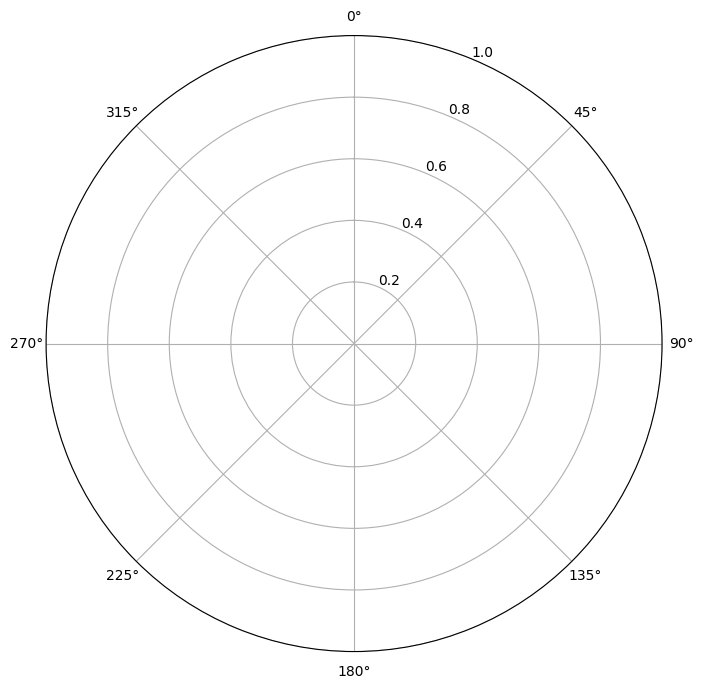

In [270]:
print("Visaul Feedback generating...")
# Save the plot as an image using the provided code
success, error_message = code_to_image(code, img_path)

In [271]:
error_message

'There are some errors in the code you gave:\nx and y must have same first dimension, but have shapes (12,) and (13,)\nplease correct the errors.'

In [272]:
if not success:
    base64_image = error_message  # Return an error message if image saving fails
else:
    # Encode the image to base64 for sending as a message
    base64_image = encode_image(img_path)
# Prepare the messages for GPT-4o, including the system prompt, user prompt with code and query, and the image
ori_query = simple_instruction

messages = [
    {
        "role": "system",
        "content": '''Given a piece of code, a user query, and an image of the current plot, please determine whether the plot has faithfully followed the user query. Your task is to provide instruction to make sure the plot has strictly completed the requirements of the query. Please output a detailed step by step instruction on how to use python code to enhance the plot. If the plot image is missing, check the error message that has occurred in the code. The error message will be provided under "ERROR MESSAGE:" and should be analyzed accordingly. Provide clear, essential instructions to modify the code based on the analysis, focusing only on the discrepancies between the plot and the user query. Avoid unnecessary feedback or suggestions. Do not output the final modified code, only the instructions.'''
    },
    {
        "role": "user",
        "content" : f'''Here is the code: [Code]:
                        """
                        {code}
                        """

                        Here is the user query: [Query]:
                        """
                        {ori_query}
                        """
                        Carefully analyze the provided Python code, user query, and the plot image (if available) to evaluate if the generated plot meets the user query requirements. If the plot image is missing, check the error message that has occurred in the code. The error message will be provided under "ERROR MESSAGE:" and should be analyzed accordingly. Compare the plot with the user query requirements, highlight discrepancies, and provide clear, essential instructions to modify the code accordingly. Additionally, suggest improvements for better visualization, focusing on clarity, readability, and alignment with the user's objectives.

                        Provide step-by-step instructions for code modification based on the analysis, focusing only on necessary corrections. Do not provide the final modified code, only the instructions for fixing the discrepancies.'''
    }
]
messages[-1]["content"] += f"\n\n![plot](data:image/png;base64,{base64_image})"

In [273]:
print(messages[-1]['content'])

Here is the code: [Code]:
                        """
                        import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Initialize a list to hold the maximum temperatures for the first of each month
monthly_max = []
for month in range(1, 13):
    max_temp = data[(data['Date'].dt.month == month) & (data['Date'].dt.day == 1)]['Temperature'].max()
    monthly_max.append(max_temp)

# Prepare the angles for the polar plot
angles = [i * (2 * np.pi / 12) for i in range(12)]
temperatures_offset = [temp + np.random.uniform(-0.5, 0.5) for temp in monthly_max]  # Offset for visibility

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direct

In [274]:
# Call the completion function to get feedback from GPT-4o
# with open('./tmp.txt', 'w') as f:
#     f.write(str(messages))
feedback = await call_openai_api(messages[0]['content'], messages[-1]['content'])
print('Feedback is done')

Feedback is done


In [275]:
print(feedback)

Based on the provided code, user query, and the error message, here are the step-by-step instructions to modify the code to ensure it meets the requirements of the user query:

1. **Fix the Data Length Issue**: The error message indicates that there is a mismatch in the dimensions of the data being plotted. The `temperatures_offset` list has 12 values (one for each month), but when you append `temperatures_offset[0]` to close the loop, it creates a list of 13 values. You need to ensure that both the `angles` and `temperatures_offset` lists have the same length (12).

   - **Instruction**: Modify the line where you create the `temperatures_offset` list to ensure it only contains 12 values. Instead of appending `temperatures_offset[0]`, you can create a new list that includes the first value at the end of the list for plotting.

2. **Change Month Labels to Abbreviations**: The user query specifies that the month labels should be abbreviated (e.g., Jan, Feb, Mar, etc.), but the current co

Visaul Feedback generating...
Start Executing Code and Save Final Image
Save Image Successfully!
Visaul Feedback generating...
Start Executing Code and Save Final Image
Save Image Successfully!
Visaul Feedback generating...
Start Executing Code and Save Final Image
There are some errors in the code you gave:
x and y must have same first dimension, but have shapes (12,) and (13,)
please correct the errors.
Feedback is done
Feedback is done
Feedback is done


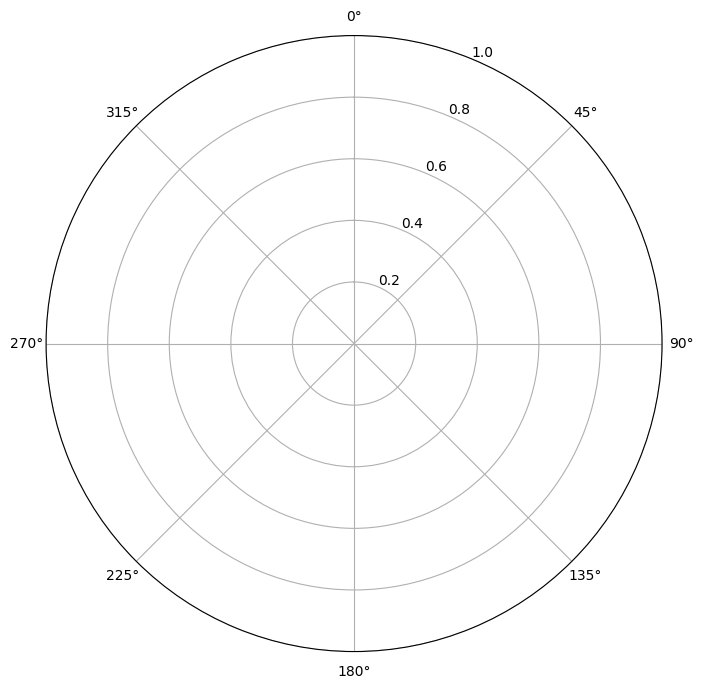

In [276]:
tasks = [visual_feedback(simple_instruction, code, new_img_path) for code, new_img_path in zip(generated_code_list, new_img_path_list)]
generated_feedback_list = await asyncio.gather(*tasks)

In [280]:
print(generated_feedback_list[2])

To address the discrepancies between the provided code and the user query, as well as to resolve the error message regarding the shapes of the x and y dimensions, follow these step-by-step instructions:

1. **Fix the Data Length Issue**:
   - The error message indicates that the lengths of the `angles` (12) and the `temperatures_offset` (13) do not match. This is due to the way the data is being prepared for plotting. 
   - Ensure that when you create the `temperatures_offset` list, you append the first temperature value to close the loop for the polar plot. However, you should only append this value after ensuring that the original list has 12 elements.

2. **Adjust the Temperature Data**:
   - Modify the line where you create `temperatures_offset` to ensure it only contains the maximum temperatures for the first of each month. You can do this by ensuring that the `monthly_max` list is correctly populated with 12 values corresponding to each month.

3. **Update the Month Labels**:
   

In [284]:
code_with_feedback = ""
for i in range(len(generated_code_list)):
    code_with_feedback += f"------\ncode{i+1}:\n{generated_code_list[i]}\n\nfeedback{i+1}:\n{generated_feedback_list[i]}\n"
print("Feedback Aggregation is done")
llm_feedback = code_with_feedback
# llm_feedback = None

Feedback Aggregation is done


In [285]:
print(llm_feedback)

------
code1:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')
data['Date'] = pd.to_datetime(data['Date'])

data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
monthly_max = data[data['Day'] == 1].groupby('Month')['Temperature'].max().reset_index()

angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.plot(angles, temperatures_offset, 'o', color='orange', label='Monthly Max Temp')
ax.plot(angles, tempe

In [291]:
prompt = template_aggregation.format(
        ori_query=simple_instruction,
        data_description=data_description,
        code_for_aggregation=llm_feedback
        )
print(prompt)

    Think step by step and plan before generating the final code.

You will be given:
- **User Query**: Instructions on how the user wants the data visualization (plot) to be performed.
- **Data Description**: Details about the dataset, including file paths and summaries.
- **Code for Aggregation with Corresponding Feedback**: Three different versions of the data visualization code, each paired with its respective feedback highlighting mismatches with the user’s requirements and areas for improvement.

### **Your Task:**
1. **Understand the User's Intent**  
   - Analyze the **User Query** to extract key visualization requirements, constraints, and goals.
   - Carefully review the **Data Description** to ensure the final visualization correctly utilizes the given dataset.

2. **Evaluate the Provided Code Versions & Feedback**  
   - Examine all three versions of the code.
   - Review the feedback for each version and identify common issues, missing elements, and improvement points.
   

In [292]:
response_text = await call_openai_api(system_prompt_codegen, prompt)
match = re.search(r"```python(.*?)```", response_text, flags=re.DOTALL)
if match:
    code = match.group(1).strip()
else:
    code = None

In [294]:
print(response_text)

To create a polar coordinate diagram that meets the user's requirements, we will follow these steps:

1. **Load the Data**: Read the CSV file and convert the 'Date' column to datetime format.
2. **Filter Data**: Extract the maximum temperatures for the first of each month from January 2004 to August 2015.
3. **Prepare Angles**: Set up the angles for the polar plot corresponding to each month.
4. **Offset Temperatures**: Add a slight random offset to the temperature values for visibility.
5. **Create Polar Plot**: Set up the polar plot with 12 sectors, plot the temperatures, and connect the points for the year 2015 with a blue curve.
6. **Customize Plot**: Add month labels, a title, and position the legend correctly.

Now, let's generate the final code based on the above plan:

```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\

In [293]:
print(code)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the first day of each month and get max temperatures from 2004 to 2015
monthly_max = data[(data['Date'].dt.day == 1) & (data['Date'].dt.year >= 2004) & (data['Date'].dt.year <= 2015)]
monthly_max = monthly_max.groupby(monthly_max['Date'].dt.month)['Temperature'].max().reset_index()

# Prepare the angles for the polar plot
angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.

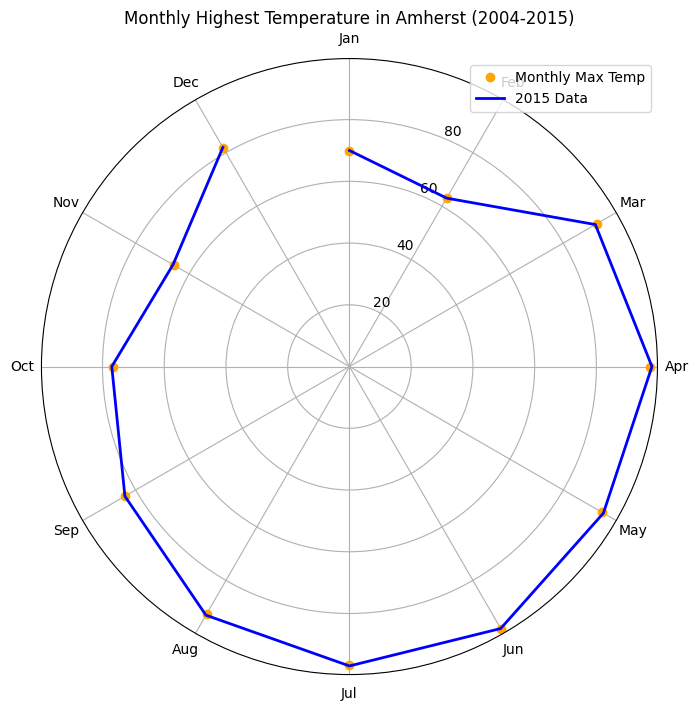

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('c:\\Users\\LeeSeungYong\\myproject\\vispath\\matplotbench\\dataset\\data\\95\\data.csv')

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data for the first day of each month and get max temperatures from 2004 to 2015
monthly_max = data[(data['Date'].dt.day == 1) & (data['Date'].dt.year >= 2004) & (data['Date'].dt.year <= 2015)]
monthly_max = monthly_max.groupby(monthly_max['Date'].dt.month)['Temperature'].max().reset_index()

# Prepare the angles for the polar plot
angles = np.linspace(0, 2 * np.pi, len(monthly_max), endpoint=False).tolist()
temperatures = monthly_max['Temperature'].values
temperatures_offset = temperatures + np.random.uniform(-1, 1, size=temperatures.shape)  # Offset for visibility

# Create a polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw the plot
ax.set_xticks(angles)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.plot(angles, temperatures_offset, 'o', color='orange', label='Monthly Max Temp')
ax.plot(angles, temperatures, color='blue', linewidth=2, label='2015 Data')
ax.set_title('Monthly Highest Temperature in Amherst (2004-2015)')
ax.legend(loc='upper right')

plt.show()